## Capstone Project


In [28]:
## Importing Data 
#import libraries
import numpy as np
import pandas as pd
#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#winsorization
from scipy.stats.mstats import winsorize

In [29]:
def scaler_transform(scaler_type, X, exclude_vars = ['latitude', 'longitude', 'id','NG_Brooklyn','NG_Manhattan','NG_Queens','NG_Bronx','NG_Staten Island','room_type_Private room','room_type_Shared room']):
    '''
    Transform the NON-object type data to the selected scaler
    '''
    X_copy = X.copy(deep = True)
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    X_notexcluded= X_copy.loc[:, ~X_copy.columns.isin(exclude_vars)]
    X_withoutobj = X_notexcluded.select_dtypes(exclude=['object'])
    #X_withoutobj = X_withoutobj.add_suffix(f'_{scaler_type}')
    # Fit transform the scaler if there are objects in dataset
    if X_withoutobj.shape[1] > 0:
        X_withoutobj = pd.DataFrame(scaler.fit_transform(X_withoutobj[X_withoutobj.columns]),
                                        index=X_withoutobj.index,
                                        columns=X_withoutobj.columns)
        # Concatenate the rest of the data
        X_withexcl = pd.concat([X_withoutobj, X.loc[:, X.columns.isin(exclude_vars)]], axis=1)
        others = [x for x in X.select_dtypes('object') if x not in X_withexcl.columns]
        X_final = pd.concat([X_withexcl,X[others]], axis=1)
    return X_final, scaler

In [10]:
## Preprocessing Code 
#importing dataset
files_dir = "../dataset/"
#filename = files_dir + "AB_NYC_2019.csv"
filename = files_dir + "listings.csv"
df = pd.read_csv(filename)
filename19 = files_dir + "AB_NYC_2019.csv"
df_2019 = pd.read_csv(filename19)
df.drop([ 'number_of_reviews_ltm'], axis=1, inplace=True)
df_2019 = df_2019.drop_duplicates(subset = ['id'], inplace=False).copy()
other_clean_df = df[~ df.id.isin(df_2019.id)]
#other_clean_df.to_csv("other_clean_df.csv")
df = pd.concat([df_2019, other_clean_df], axis=0, ignore_index=True)
#drop duplicates
df_duplicates = df.drop_duplicates(subset = ['id'], inplace=False).copy()
#data types
df_duplicates['id'] = df_duplicates['id'].fillna(0)
df_duplicates['id'] = df_duplicates['id'].astype(int)
df_duplicates['host_id'] = df_duplicates['host_id'].fillna(0)
df_duplicates['host_id'] = df_duplicates['host_id'].astype(int)
#missing data
df_missing = df_duplicates.copy(deep=True)
#dropping irrelevant columns
df_missing.drop(['host_id','host_name'], axis=1, inplace=True)
#replacing missing values
df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())] = df_missing[(df_missing.last_review.isnull()) & (df_missing.reviews_per_month.isnull())].replace(np.nan,0)
#dropping irrelevant columns
df_missing.drop(['last_review'], axis=1, inplace=True)
#dropping rows with NaN in listing names
df_missing.dropna(subset = ['name'], inplace= True)
#feature encoding
df_encode = df_missing.copy(deep=True)
df_encode['neighbourhood_group']=pd.factorize(df_encode.neighbourhood_group)[0]
df_encode['neighbourhood']=pd.factorize(df_encode.neighbourhood)[0]
df_encode['room_type']=pd.factorize(df_encode.room_type)[0]
#truncate minimum nights
df_win = df_encode.copy(deep=True)
df_win['minimum_nights'] = winsorize(df_win['minimum_nights'], limits=(0, 0.075))
#to remove the skeweness of the price
df_log = df_win.copy(deep=True)
df_log['price'] =  np.log1p(df_log['price'])
#integrate the geodata dataframe
geodata = pd.read_csv('../merged_map.csv')
geodata_sub = pd.read_csv('../dataset/subway_data.csv')
df_all = df_log.copy()
df_all = df_all.merge(geodata, left_on = 'id', right_on = 'id')
df_all = df_all.merge(geodata_sub, left_on = 'id', right_on = 'id')
df_all.drop(['geom_x','geom_y'], axis=1, inplace=True)
#scale the numeric features 
df_std = df_all.copy(deep=True)
df_std, scaler = scaler_transform('standard', df_std, exclude_vars = ['price','latitude', 'longitude', 'id','NG_Brooklyn','NG_Manhattan','NG_Queens','NG_Bronx','NG_Staten Island','room_type_Private room','room_type_Shared room'])

In [41]:
##  bins 
from sklearn.preprocessing import KBinsDiscretizer,LabelEncoder
from sklearn.model_selection import train_test_split
trans = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_new = df_std.copy(deep=True)
df_new['price_bins'] = trans.fit_transform(np.array(df_new['price']).reshape(-1,1))
## data Splitting for classification
y = df_new['price_bins']
#X = df_class.drop(['neighbourhood_group','name','id'], axis=1)
X = df_new.drop(['price','name','id', 'price_bins'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

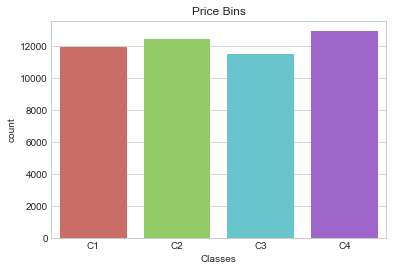

In [42]:
# Visualize the Split
fig = plt.Figure(figsize=(10,8))
sns.countplot(df_new['price_bins'],palette = "hls")
labels = ['C1', 'C2','C3','C4']
positions  = [0,1, 2,3]
plt.xticks(positions, labels)
plt.title('Price Bins')
plt.xlabel('Classes')
plt.show()

## Benchmarking Classification Models

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

xgboost_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=4, random_state=42, max_depth = 8)
xgboost_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], 
             verbose=False)
y_pred = xgboost_model.predict(X_test)
confusion_matrix(y_test,y_pred)

[12:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[4288,  849,   80],
       [1153, 2770, 1365],
       [ 199, 1135, 4265]])

In [15]:
print("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.7031172379533035


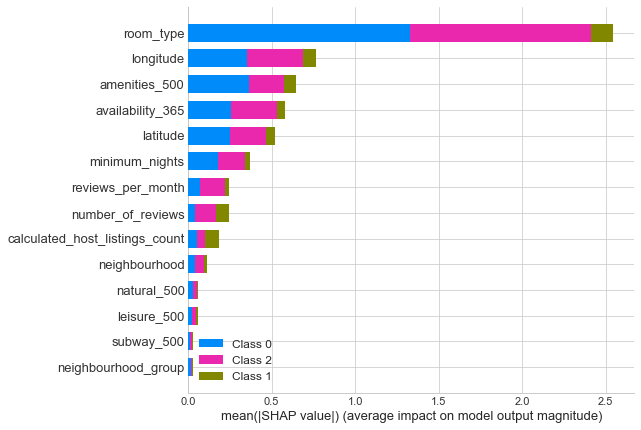

In [16]:
import shap
explainer = shap.TreeExplainer(xgboost_model)
X_sampled = X_train.sample(500, random_state=10)
shap_values = explainer.shap_values(X_sampled)
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
# evaluate model
from sklearn.model_selection import  cross_validate
cv = StratifiedKFold(n_splits=5, random_state=432, shuffle = True)

In [21]:
lgb_grid_search= GridSearchCV(estimator = xgboost_model, param_grid={'max_depth': [4,8,10], 'n_estimators': [10, 30], 'num_leaves': [4,16] }, n_jobs = -1, cv = cv, scoring = 'roc_auc', error_score=0, verbose = -1)
lgb_grid_win = lgb_grid_search.fit(X_train, y_train)

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-pack

[17:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Use

[17:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:03:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with th

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'.

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'.

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'.

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/pytho

[17:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
lgb_grid_win

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=432, shuffle=True),
             error_score=0,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.05, max_delta_step=0,
                                     max_depth=8, min_child...
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=1000, n_jobs=4,
                                     num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', random_state=42,
      

In [23]:
# Get the estimator
best_clf_rf = lgb_grid_win.best_estimator_
best_clf_rf
#results in data frame
rf_results = pd.DataFrame(lgb_grid_win.cv_results_)
# show the first 5 rows
display(rf_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.388145,0.015089,0.001718,0.000504,4,10,4,"{'max_depth': 4, 'n_estimators': 10, 'num_leav...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.353297,0.021284,0.003007,0.001843,4,10,16,"{'max_depth': 4, 'n_estimators': 10, 'num_leav...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,4.351970,0.034476,0.001319,0.000737,4,30,4,"{'max_depth': 4, 'n_estimators': 30, 'num_leav...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4.326183,0.023733,0.000931,0.000350,4,30,16,"{'max_depth': 4, 'n_estimators': 30, 'num_leav...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,3.603002,0.356293,0.000841,0.000057,8,10,4,"{'max_depth': 8, 'n_estimators': 10, 'num_leav...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [24]:
best_clf_rf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=4,
              num_leaves=4, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [27]:

scores = cross_validate(xgboost_model, X_train, y_train, cv = cv,
                         scoring=('roc_auc', 'accuracy'),
                         return_train_score=True, n_jobs=-1)

/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Use

[17:15:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers sta

[17:15:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/daniela/Documents/myRepos/housing_prediction_ny/ENV/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/daniela/Document

In [26]:
scores

{'fit_time': array([0.69163895, 0.68661928, 0.6946249 , 0.69842005, 0.66301203]),
 'score_time': array([0.00175095, 0.0014708 , 0.00149512, 0.00154305, 0.00175476]),
 'test_roc_auc': array([nan, nan, nan, nan, nan]),
 'train_roc_auc': array([nan, nan, nan, nan, nan]),
 'test_accuracy': array([nan, nan, nan, nan, nan]),
 'train_accuracy': array([nan, nan, nan, nan, nan])}

In [14]:
## test lr and rf 

In [ ]:
# Get the estimator
best_clf_rf = lgb_grid_win.best_estimator_
best_clf_rf
#results in data frame
rf_results = pd.DataFrame(lgb_grid_win.cv_results_)
# show the first 5 rows


NameError: name 'rf_grid_win' is not defined

In [3]:
rf_grid_win

NameError: name 'rf_grid_win' is not defined